In [1]:
import time
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddlenlp as ppnlp
from functools import partial
from paddlenlp.datasets import load_dataset
from paddlenlp.transformers import LinearDecayWithWarmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# 解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用于正常显示正负号


In [2]:
train = pd.read_excel('data/data_train.xlsx')
test = pd.read_excel('data/data_test.xlsx')
train.head(5)

,id,age,diseaseName,conditionDesc,title,hopeHelp,label_i,label_j
0,0,20+,刨腹产可以养三胎吗？,刨腹产可以养三胎吗？希望医生能帮我看看，谢谢！,刨腹产可以养三胎吗？,前两个都是刨腹产，时间已经隔了有6年了，前两个都很顺利，想问问医生现在可以养三胎吗？,1,8
1,1,20+,右膝前交叉韧带断裂，半月板三度重度损伤,右膝受力小腿骨和大腿骨就会滑开，走路会有隐隐作痛,大概做韧带重建手术需要多少费用？,大概做韧带重建手术需要多少费用？,18,57
2,2,30+,没有不适，就是左眼球有红色充血,昨天我朋友跟我说，我的左眼睛有红色的问我怎么啦，我自己都不知道，所以现在问医生看需要去医院吗...,需要怎么治疗,需要怎么治疗,15,45
3,3,30+,腿摔了,一个月前从摩托上摔下来了，拍了片子和核磁共振，打的石膏，腿直不了,腿可能这辈子就瘸了,请医生给我一些治疗上的建议，目前病情是否需要手术？，是否需要就诊？就诊前做哪些准备？,18,58
4,4,30+,体检单问题,偶尔会拉肚子或便秘 胃肠偶尔不舒服 没有疼痛感,体检单问题咨询 需要治疗吗,单位体检遇到的问题,2,-1


In [3]:
# 查看数据详细信息，检查缺失情况
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22868 entries, 0 to 22867
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             22868 non-null  int64 
 1   age            22868 non-null  object
 2   diseaseName    22868 non-null  object
 3   conditionDesc  22868 non-null  object
 4   title          21627 non-null  object
 5   hopeHelp       21182 non-null  object
 6   label_i        22868 non-null  int64 
 7   label_j        22868 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.4+ MB


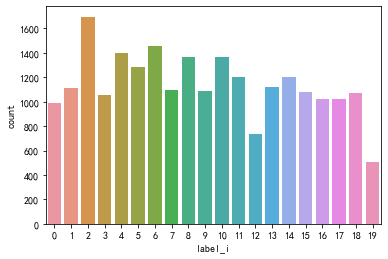

In [4]:
%matplotlib inline
# 统计 label_i的数目
sns.countplot(x='label_i', data=train)
plt.show()

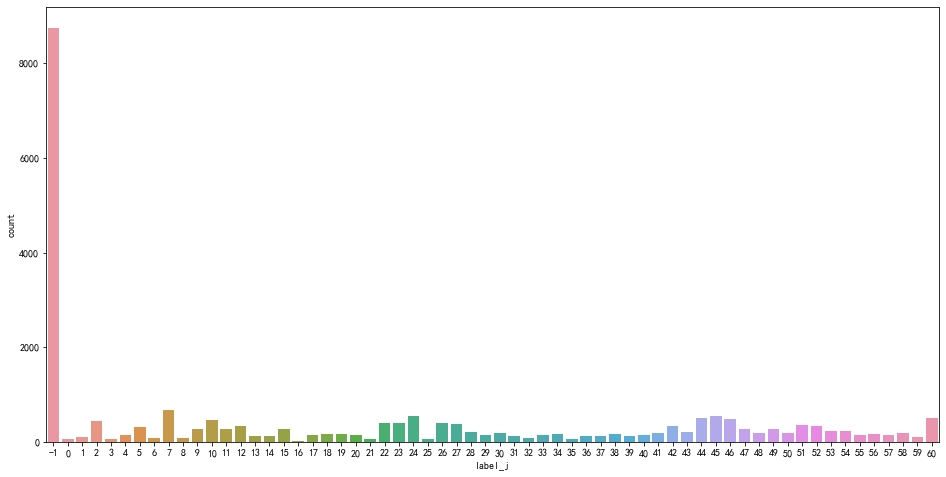

In [5]:
%matplotlib inline
# 统计label_j
plt.figure(figsize=(16, 8))
sns.countplot(x='label_j', data=train)
plt.show()

266


<AxesSubplot:xlabel='text_length', ylabel='Density'>

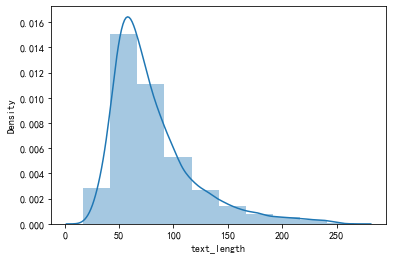

In [9]:
%matplotlib inline
# 统计文本长度
merge_col = ['diseaseName', 'conditionDesc', 'title', 'hopeHelp']
train['text_length'] = [len(''.join([str(rows[jol]) for jol in merge_col])) for _, rows in train.iterrows()]
print(train['text_length'].max())
sns.distplot(train['text_length'], bins=10)


分析：
- 多个字段存在数据缺失
- 标签类别不平衡
- 长度最大值小于266，文本截断长度取256？


## 数据预处理

In [10]:
seed = 1234

# 设置随机种子 固定结果
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    paddle.seed(seed)

set_seed(seed)

步骤：
- 填补缺失值
- 拼接文本内容
- 划分数据集
- 转换为bert编码格式

In [13]:
def clean_str(x):
    return x.replace('r', '').replace('\t', ' ').replace('\n', ' ')

# 清晰和填补缺失值
merge_col = ['diseaseName', 'conditionDesc', 'title', 'hopeHelp']
for col in merge_col:
    train[col].fillna('', inplace=True)
    test[col].fillna('', inplace=True)
    train[col] = train[col].apply(lambda x: clean_str(x))
    test[col] = test[col].apply(lambda x: clean_str(x))

# 拼接文本
train["sentence"] = [",".join([rows[jol] for jol in merge_col if len(rows[jol])>0]) for _,rows in train.iterrows()]
test["sentence"] = [",".join([rows[jol] for jol in merge_col if len(rows[jol])>0]) for _,rows in test.iterrows()]


# 数据集划分
train_ds, dev_ds, _, _ = train_test_split(train, train['id'], test_size=0.1, random_state=seed)

# 转换为json
def read(df, label_name=None):
    if label_name:
        for idx, rows in df.iterrows():
            yield {'sentence': str(rows['sentence']), 'label': rows[label_name]}
    else:
        for idx, rows in df.iterrows():
            yield {'sentence': str(rows['sentence'])}

# label_i 训练集
train_i_ds = train_ds[['sentence', 'label_i']]
dev_i_ds = dev_ds[['sentence', 'label_i']]

# label_j训练集，直接删除包含-1未知标签的样本
train_j_ds = train_ds[["sentence","label_j"]]
dev_j_ds = dev_ds[["sentence","label_j"]]
train_j_ds = train_j_ds[train_j_ds["label_j"]!=-1]
dev_j_ds = dev_j_ds[dev_j_ds["label_j"]!=-1]

# 统计类别数量
class_i_nums = train_i_ds["label_i"].value_counts().shape[0]
class_j_nums = train_j_ds["label_j"].value_counts().shape[0]
print("label_i_num:{} label_j_num:{}".format(class_i_nums,class_j_nums))

# 使用paddle的load_dataset，通过read函数，将所有数据转变为json格式
train_i_ds = load_dataset(read,df=train_i_ds,label_name="label_i",lazy=False)
dev_i_ds = load_dataset(read,df=dev_i_ds,label_name="label_i",lazy=False)

train_j_ds = load_dataset(read,df=train_j_ds,label_name="label_j",lazy=False)
dev_j_ds = load_dataset(read,df=dev_j_ds,label_name="label_j",lazy=False)

# 测试集 
test_ds = load_dataset(read,df=test[["sentence"]],label_name=None,lazy=False)

# 文本到BERT编码的函数
def convert_example(example, tokenizer):
    encoded_inputs = tokenizer(text=example["sentence"],
                               max_seq_len=max_seq_len,
                               pad_to_max_seq_len=True)
    return tuple([np.array(x, dtype="int64") for x in [
            encoded_inputs["input_ids"], encoded_inputs["token_type_ids"], [example["label"]]]])

def convert_predict_example(example, tokenizer):
    encoded_inputs = tokenizer(text=example["sentence"],
                               max_seq_len=max_seq_len,
                               pad_to_max_seq_len=True)
    return tuple([np.array(x, dtype="int64") for x in [
            encoded_inputs["input_ids"], encoded_inputs["token_type_ids"]]])


label_i_num:20 label_j_num:61


## 创建模型

In [17]:
class TextClassification(nn.Layer):
    def __init__(self, pretrained_model,num_class,dropout=None):
        super().__init__()
        self.ptm = pretrained_model
        self.dropout = nn.Dropout(dropout if dropout is not None else 0.1)
        self.classifier = nn.Linear(self.ptm.config["hidden_size"], num_class)

    def forward(self, input_ids, token_type_ids=None, position_ids=None, attention_mask=None):
        _, cls_embedding = self.ptm(input_ids=input_ids, token_type_ids=token_type_ids,attention_mask=attention_mask)
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)

        return logits

## 模型配置